In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4622,20-10-2023,28.0153
4623,23-10-2023,28.0218
4624,24-10-2023,28.0608
4625,25-10-2023,28.1042


In [4]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [5]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


In [6]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [7]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
207,2023-5,1300.60
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31


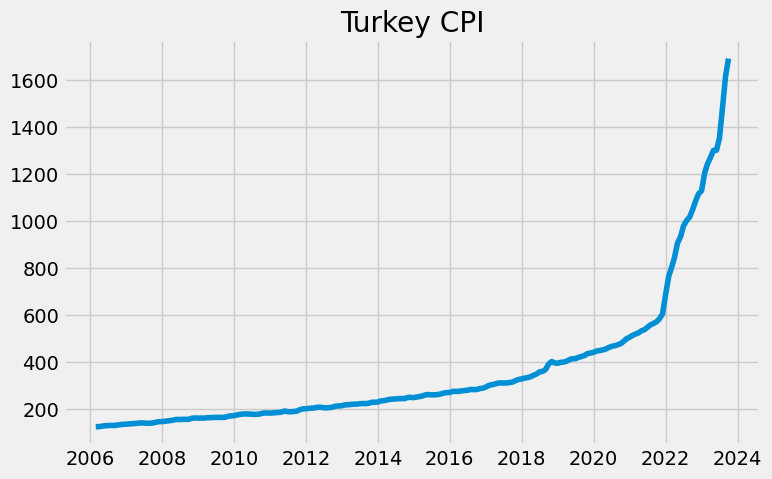

In [8]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [9]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127


In [10]:
dates= pd.date_range('2006-02-01','2023-11-01' , freq='1M')           
df6=df6.set_index(dates)
df6


,USD/TL
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [11]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
del money["Tarih"]
money['Tarih'] = pd.to_datetime(money['YEARWEEK'] + '-1', format='%Y-%W-%w')
money = money.groupby(money['Tarih'].dt.to_period('M'))['TP_PR_ARZ13'].mean()
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(df6.index)
money

,Para Arzi
2006-02-28,2.424295
2006-03-31,2.473023
2006-04-30,2.514337
2006-05-31,2.648480
2006-06-30,2.794302
...,...
2023-06-30,104.034758
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258


In [12]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(df6.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-06-30,111.098957
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411


In [13]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-09-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-04-30,10.0
2023-05-31,9.5
2023-06-30,9.6
2023-07-31,9.4


In [14]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4614,10-10-2023,90.70
4615,11-10-2023,87.58
4616,12-10-2023,88.40
4617,13-10-2023,94.33


In [15]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

brent

,TP_BRENTPETROL_EUBP
Tarih,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [16]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])
df14

,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-06-30,74.839091
2023-07-31,80.108095
2023-08-31,86.147727


In [17]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
208,2023-6,9.564604e+09
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10


In [18]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
208,2023-6,95.646045
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870


In [19]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=dates
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-06-30,95.646045
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870


In [20]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.50
1,2006-3,17.50
2,2006-4,17.50
3,2006-5,17.50
4,2006-6,17.50
...,...,...
208,2023-6,12.84
209,2023-7,17.50
210,2023-8,23.50
211,2023-9,31.00


In [21]:
dates=pd.date_range('2006-02-28','2023-11-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.50
2006-03-31,17.50
2006-04-30,17.50
2006-05-31,17.50
2006-06-30,17.50
...,...
2023-06-30,12.84
2023-07-31,17.50
2023-08-31,23.50


In [22]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-11-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.297500
2006-03-31,17.008000
2006-04-30,16.207500
2006-05-31,16.300000
2006-06-30,19.670000
...,...
2023-06-30,38.560000
2023-07-31,45.825000
2023-08-31,45.765000
2023-09-30,56.350000


In [23]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:169,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:169,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-09-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-04-30,165.916139,169.886079,174.404111
2023-05-31,181.176925,179.726145,180.185729
2023-06-30,180.070938,186.141640,180.131292
2023-07-31,191.355951,193.831190,185.482059


In [24]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-10-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-05-31,18.920000
2023-06-30,22.100000
2023-07-31,29.480000
2023-08-31,37.370000


In [25]:
sanayi=evds.get_data(["TP.SANAYREV4.Y1"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
sanayi=sanayi.set_index(pd.date_range(start="2006-02-01",end="2023-09-01",freq="1M"))
del sanayi["Tarih"]
sanayi.columns=["Sanayi"]
sanayi

,Sanayi
2006-02-28,55.819129
2006-03-31,65.933232
2006-04-30,62.501869
2006-05-31,66.499838
2006-06-30,67.519860
...,...
2023-04-30,129.873251
2023-05-31,149.379361
2023-06-30,137.891848
2023-07-31,145.483816


In [26]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-11-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.760000
2006-03-31,15.330000
2006-04-30,15.175000
2006-05-31,14.925000
2006-06-30,15.584000
...,...
2023-06-30,39.592000
2023-07-31,33.125000
2023-08-31,29.412500
2023-09-30,41.656000


In [27]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-11-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-06-30,7.55
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30


In [28]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate="30-10-2023",frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-10-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-05-31,2.348115e+09
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09


In [29]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate="30-10-2023",frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-10-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-05-31,94.52
2023-06-30,87.07
2023-07-31,81.77
2023-08-31,84.81


In [30]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate="30-10-2023",frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-10-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-05-31,58.00
2023-06-30,51.60
2023-07-31,48.71
2023-08-31,52.42


In [31]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.head(211)
data=data.dropna(axis=0)
data

,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,REDK,REDKT,M3,TÜFE
2011-04-30,-0.810542,2.440539,-1.218711,-0.176965,-3.796845,0.684613,2.978727,1.593625,2.284537,1.642254,0.866270
2011-05-31,-0.399628,0.458932,-1.660706,1.110822,4.626047,0.570506,3.568114,-3.090570,-1.121135,0.477281,2.420827
2011-06-30,0.415548,1.955789,2.055258,2.490629,4.308985,0.194110,3.122424,-1.878794,-3.463549,2.450559,-1.430743
2011-07-31,2.804715,1.982717,2.237631,1.258223,-1.324582,0.019793,2.898935,-3.289474,-3.817214,2.189939,-0.409400
2011-08-31,3.747733,0.951638,1.664460,-0.296514,-3.655736,0.318355,3.279260,-4.213626,-5.533295,0.444077,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,3.880167,-1.492537,0.772387,-14.132513,10.507274,5.406548,-2.000628,-0.873069,4.189763,2.385509
2023-05-31,1.507585,4.857908,-7.526882,3.315070,15.019343,2.663712,3.535416,1.026080,-1.761518,4.796282,0.043076
2023-06-30,7.066073,0.788974,16.807611,-0.030212,-7.690161,2.406884,5.711697,-7.881930,-11.034483,-1.142443,3.920498
2023-07-31,11.475241,9.567224,33.393665,2.970482,5.505741,9.689321,5.675617,-6.087056,-5.600775,15.439600,9.488824


In [32]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','Şok','M3','İşsizlik',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,TÜFE
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,-13.258747,0.82,1.817559,-0.584687,3.267877,9.0220,-3.691204,-5.094658,1,3.413428,9.2,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-4.776023,0.73,3.306415,0.808574,1.451593,10.6275,2.179150,0.919060,0,2.079333,9.5,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,12.632839,0.80,0.500514,0.193691,0.341852,11.3125,0.471546,0.641623,1,0.229599,9.5,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-1.068156,0.73,1.106676,0.478162,0.129671,11.0200,4.682667,5.892031,1,0.730196,9.7,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,1.476989,0.80,-0.699811,0.091080,0.468727,10.4940,1.283880,2.058652,0,-0.093468,9.7,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,0.963176,-1.492537,0.772387,29.2275,0.00,-14.132513,7.51,3.880167,10.507274,5.406548,28.3425,-2.000628,-0.873069,0,4.189763,10.0,2.385509
2023-05-31,1.507585,-7.526882,3.315070,32.0225,0.00,15.019343,7.37,4.857908,2.663712,3.535416,31.4625,1.026080,-1.761518,0,4.796282,9.5,0.043076
2023-06-30,7.066073,16.807611,-0.030212,38.5600,0.00,-7.690161,7.55,0.788974,2.406884,5.711697,39.5920,-7.881930,-11.034483,0,-1.142443,9.6,3.920498
2023-07-31,11.475241,33.393665,2.970482,45.8250,34.00,5.505741,7.70,9.567224,9.689321,5.675617,33.1250,-6.087056,-5.600775,1,15.439600,9.4,9.488824


In [33]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'ParaArzi', 'REDK', 'REDKT', 'M3']
X = data[features]
y=data["TÜFE"]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()
model=LinearRegression()
model.fit(X_train,y_train)

        

rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [34]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Borç', 'REDKT', 'M3', 'İşsizlik']
X = data[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [35]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Borç', 'M3']
X = data[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [36]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Borç', 'M3']
X = data[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [37]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Kredi Faizi', 'Zam', 'Sanayi', 'Kredi', 'REDK']
X = data[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [38]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import xgboost as xg
warnings.filterwarnings("ignore")
features=['USDTL', 'ParaArzi', 'Mevduat Faizi', 'Şok', 'İşsizlik']
X = data[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()
model = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 50, seed = 123)
model.fit(X_train,y_train)

tahminler["XGBoost"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["XGBoost"])))

In [39]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Zam', 'Borç', 'M3']
X = data[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [40]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDK', 'REDKT', 'Şok']
X = data[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [41]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'ParaArzi', 'Borç', 'Mevduat Faizi','Şok']
X = data[features]
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.1,random_state=3)
X_train=X_train.sort_index()
X_test=X_test.sort_index()
y_train=y_train.sort_index()
y_test=y_test.sort_index()
model = tf.keras.models.Sequential()
model.add(Dense(units=64,input_dim=X_train.shape[1],activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(16,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.01),loss="mae",metrics=["mae"])
cıktı=model.fit(X_train,y_train,epochs=100,verbose=0)
        



tahminler["Deep Neural Network"]=model.predict(X_test)
rmse.append((np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Deep Neural Network"]))))

1/1 [==============================] - 0s 98ms/step


In [42]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Linear Regression,0.637851
Bayesian Regression,0.665442
Deep Neural Network,0.843398
SGD Regressor,0.992291
Lasso Regression,1.017423
Gaussian Regression,1.041934
Kernel Regression,1.184516
Lars Regression,1.278306
XGBoost,2.084798


In [43]:
tahminler

,Aylık Enflasyon,Linear Regression,Bayesian Regression,Lasso Regression,SGD Regressor,Lars Regression,XGBoost,Gaussian Regression,Kernel Regression,Deep Neural Network
2014-06-30,0.310791,-0.019311,0.315633,0.264094,0.166781,-0.220590,0.073168,0.139607,1.012860,0.335354
2014-07-31,0.454414,1.113068,0.872328,0.676212,0.628841,-0.056159,0.220408,0.549840,0.716268,0.413586
2016-02-29,-0.021863,1.108942,0.891760,0.643728,0.573597,0.580908,0.320934,0.542141,0.333650,0.535581
2017-05-31,0.446270,0.545564,0.385335,0.248314,0.193118,0.296699,-0.147589,0.152330,0.470025,0.749253
2017-07-31,0.148492,0.297099,0.463400,0.603525,0.547643,-0.187633,0.090285,0.505141,0.410499,1.004211
2020-12-31,1.249549,1.243803,0.799425,0.728236,0.621385,0.595115,1.873239,0.545942,2.045963,2.478383
2021-02-28,0.907851,0.130189,-0.251773,-0.416308,-0.531674,-0.386322,1.110848,-0.573241,0.678145,0.128107
2022-02-28,4.808511,5.038083,4.447146,3.794386,3.845359,4.786924,3.207893,3.792993,5.185003,2.955062
2022-03-31,5.464228,5.545221,5.419537,5.018255,5.066977,3.421099,4.259708,4.914650,9.016230,6.058510
2022-05-31,2.980802,1.667790,2.160714,2.168129,2.178283,4.120097,0.615773,2.132984,4.207326,1.961270


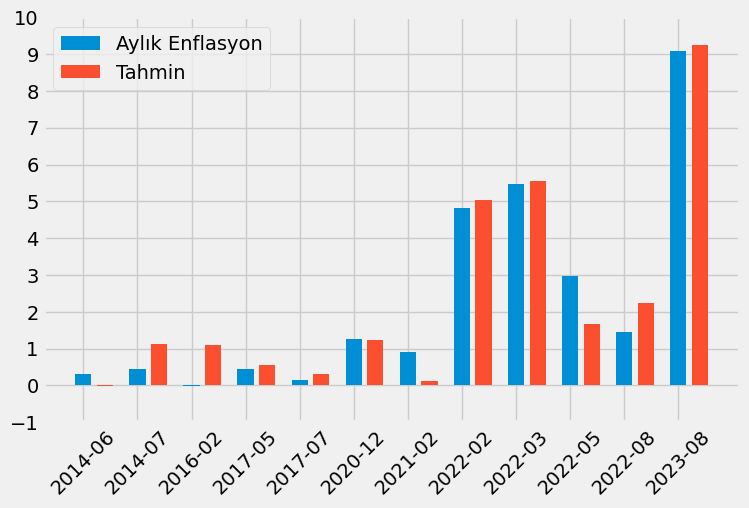

In [44]:
X_axis = np.arange(len(tahminler))
plt.figure(figsize=(8,5)) 
plt.bar(X_axis,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
plt.bar(X_axis+0.4,tahminler["Linear Regression"],width=0.3,label="Tahmin")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.yticks(np.arange(-1,11,1))
plt.legend()

In [45]:
from statsmodels.tsa.arima.model import ARIMA

model = SARIMAX(df6["USD/TL"], order=(0,1,1),seasonal_order=(1,1,0,12))
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=15)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[208:,0]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.791032
2023-11-30,28.837909
2023-12-31,30.840471
2024-01-31,30.875456
2024-02-29,30.965193
2024-03-31,31.639358


In [46]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import month_plot
import warnings


model = SARIMAX(df14["Brent"], order=(1, 1, 0), seasonal_order=(2, 1, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 15# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
brenttahmin=pd.DataFrame(forecast_values)
brenttahmin.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[209:213,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M"))
brenttahmin=pd.concat([row,brenttahmin],axis=0)
brenttahmin

,Brent
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,90.455455
2023-11-30,88.343082
2023-12-31,85.431383
2024-01-31,90.291657
2024-02-29,95.526542
2024-03-31,99.282546
2024-04-30,98.923810


In [47]:
model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(1,1,1),seasonal_order=(0,1,1,12))
model_fit = model.fit()
perakendetahmin = model_fit.forecast(steps=15)
perakendetahmin=pd.DataFrame(perakendetahmin)
perakendetahmin.columns=["Perakende"]
row=pd.DataFrame({"Perakende":perakende1.iloc[163,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
perakendetahmin=pd.concat([row,perakendetahmin],axis=0)
perakendetahmin

,Perakende
2023-08-31,184.748497
2023-09-30,177.058336
2023-10-31,178.125306
2023-11-30,179.371911
2023-12-31,179.533206
2024-01-31,180.650546
2024-02-29,180.458038
2024-03-31,182.407175
2024-04-30,180.242428
2024-05-31,181.499598


In [48]:
model = SARIMAX(money["Para Arzi"], order=(2,1,2),seasonal_order=(0,1,1,12))
model_fit = model.fit()


# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
paraarzitahmin=pd.DataFrame(forecast_values)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209:213,0]},index=pd.date_range(start="2023-07-30",end="2023-11-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-07-31,113.228626
2023-08-31,119.111278
2023-09-30,122.425258
2023-10-31,125.040807
2023-11-30,129.186754
2023-12-31,134.195424
2024-01-31,137.856381
2024-02-29,141.854840
2024-03-31,146.657833
2024-04-30,151.630687


In [49]:
model = SARIMAX(kfaiz["Kredi Faizi"], order=(1,1,0),seasonal_order=(1,1,2,12))
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kfaiztahmin=pd.DataFrame(forecast_values)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.713333
2023-11-30,60.147187
2023-12-31,60.919418
2024-01-31,61.060058
2024-02-29,59.402961
2024-03-31,58.474743
2024-04-30,58.427005
2024-05-31,59.053824


In [50]:
model = ARIMA(mfaiz, order=(3, 1, 0))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 15 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
mfaiztahmin=pd.DataFrame(forecast_values)
mfaiztahmin.columns=["Mevduat Faizi"]
new_row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
mfaiztahmin=pd.concat([new_row,mfaiztahmin],axis=0)
mfaiztahmin

,Mevduat Faizi
2023-08-31,29.412500
2023-09-30,41.656000
2023-10-31,44.616667
2023-11-30,36.577175
2023-12-31,39.331064
2024-01-31,46.705823
2024-02-29,43.043976
2024-03-31,39.183307
2024-04-30,44.280656
2024-05-31,46.151471


In [51]:
usdtahmin["brent"]=brenttahmin
usdtahmin=usdtahmin.dropna(axis=0)
degisim=pd.DataFrame((((usdtahmin["USDTL"]*usdtahmin["brent"]).pct_change(periods=1)+1).values)[1:],index=pd.date_range(start="2023-08-30",end="2025-02-27",freq="1M"))
degisim.columns=["Değişim"]
degisim=degisim.iloc[1:17]
degisim

,Değişim
2023-09-30,1.087536
2023-10-31,0.993807
2023-11-30,1.013437
2023-12-31,1.034194
2024-01-31,1.058090
2024-02-29,1.061052
2024-03-31,1.061947
2024-04-30,1.002415
2024-05-31,1.020205
2024-06-30,1.101783


In [52]:
motorintahmin=pd.DataFrame()
motorintahmin["Değişim"]=degisim
motorintahmin["Motorin"]=39.18
for i in range(1,16):
    motorintahmin.iloc[i,1]=motorintahmin.iloc[i,0]*motorintahmin.iloc[i-1,1]

del motorintahmin["Değişim"]
new_row=pd.DataFrame({"Motorin":motorin.iloc[247,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-08-31,37.370000
2023-09-30,39.180000
2023-10-31,38.937364
2023-11-30,39.460577
2023-12-31,40.809903
2024-01-31,43.180546
2024-02-29,45.816822
2024-03-31,48.655024
2024-04-30,48.772520
2024-05-31,49.757952


In [53]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2025-01-30",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [54]:
model = ARIMA(df3["Kredi"], order=(3, 1, 3))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 16 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kreditahmin=pd.DataFrame(forecast_values)
kreditahmin.columns=["Kredi"]
new_row=pd.DataFrame({"Kredi":[99.23,102.58,103.18]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
kreditahmin=pd.concat([new_row,kreditahmin],axis=0)
kreditahmin

,Kredi
2023-08-31,99.230000
2023-09-30,102.580000
2023-10-31,103.180000
2023-11-30,103.503120
2023-12-31,105.765667
2024-01-31,107.369391
2024-02-29,106.925230
2024-03-31,108.530284
2024-04-30,110.344978
2024-05-31,109.795718


In [55]:
model = ARIMA(borc["Borç"], order=(1, 1, 2), seasonal_order=(1, 0, 1, 12))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
borctahmin=pd.DataFrame(forecast_values)
borctahmin.columns=["Borç"]
new_row=pd.DataFrame({"Borç":2758965144},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
borctahmin=pd.concat([new_row,borctahmin],axis=0)
borctahmin

,Borç
2023-08-31,2.758965e+09
2023-10-31,2.934016e+09
2023-11-30,3.005940e+09
2023-12-31,3.069800e+09
2024-01-31,3.128332e+09
2024-02-29,3.183702e+09
2024-03-31,3.236235e+09
2024-04-30,3.280363e+09
2024-05-31,3.321218e+09
2024-06-30,3.360512e+09


In [56]:
model = SARIMAX(redk["REDK"], order=(2, 1, 0), seasonal_order=(1, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redktahmin=pd.DataFrame(forecast_values)
redktahmin.columns=["REDK"]
new_row=pd.DataFrame({"REDK":[84.81,88.29]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
redktahmin=pd.concat([new_row,redktahmin],axis=0)
redktahmin

,REDK
2023-08-31,84.810000
2023-09-30,88.290000
2023-10-31,87.997770
2023-11-30,87.214358
2023-12-31,85.531698
2024-01-31,86.984450
2024-02-29,88.983093
2024-03-31,88.439166
2024-04-30,88.321581
2024-05-31,88.268137


In [57]:
model = SARIMAX(redkt["REDKT"], order=(2, 1, 0), seasonal_order=(1, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 16# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redkttahmin=pd.DataFrame(forecast_values)
redkttahmin.columns=["REDKT"]
new_row=pd.DataFrame({"REDKT":[52.42,55.52]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
redkttahmin=pd.concat([new_row,redkttahmin],axis=0)
redkttahmin

,REDKT
2023-08-31,52.420000
2023-09-30,55.520000
2023-10-31,55.807175
2023-11-30,54.435473
2023-12-31,52.551396
2024-01-31,53.485479
2024-02-29,54.657562
2024-03-31,53.617185
2024-04-30,53.457812
2024-05-31,52.151740


In [58]:
model = ARIMA(m3["M3 Para Arzi"], order=(1, 1, 1))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 15# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
m3tahmin=pd.DataFrame(forecast_values)
m3tahmin.columns=["M3 Para Arzi"]
new_row=pd.DataFrame({"M3 Para Arzi":[123.43,126.66,127.9]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
m3tahmin=pd.concat([new_row,m3tahmin],axis=0)
m3tahmin

,M3 Para Arzi
2023-08-31,123.430000
2023-09-30,126.660000
2023-10-31,127.900000
2023-11-30,134.438904
2023-12-31,138.847986
2024-01-31,143.245383
2024-02-29,147.631128
2024-03-31,152.005250
2024-04-30,156.367780
2024-05-31,160.718749


In [59]:
model = SARIMAX(issizlik["İşsizlik"], order=(0, 1, 1), seasonal_order=(1, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 17# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
issizliktahmin=pd.DataFrame(forecast_values)
issizliktahmin.columns=["İşsizlik"]
new_row=pd.DataFrame({"İşsizlik":[9.2]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
issizliktahmin=pd.concat([new_row,issizliktahmin],axis=0)
issizliktahmin

,İşsizlik
2023-08-31,9.200000
2023-09-30,9.128270
2023-10-31,9.096536
2023-11-30,9.149132
2023-12-31,9.186304
2024-01-31,9.256840
2024-02-29,9.307002
2024-03-31,9.341871
2024-04-30,9.415606
2024-05-31,9.422929


In [60]:
model = SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"], order=(0, 1, 0), seasonal_order=(0, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 17# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
enfbelirsizliktahmin=pd.DataFrame(forecast_values)
enfbelirsizliktahmin.columns=["Enflasyon Belirsizliği"]
new_row=pd.DataFrame({"Enflasyon Belirsizliği":[6.81,7.3,5.57]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([new_row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin

,Enflasyon Belirsizliği
2023-08-31,6.810000
2023-09-30,7.300000
2023-10-31,5.570000
2023-11-30,5.805533
2023-12-31,6.972540
2024-01-31,7.940352
2024-02-29,6.897245
2024-03-31,7.419293
2024-04-30,7.356433
2024-05-31,7.693614


In [61]:
model = SARIMAX(sanayi["Sanayi"], order=(0, 1, 1), seasonal_order=(2, 1, 1, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 17# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
sanayitahmin=pd.DataFrame(forecast_values)
sanayitahmin.columns=["Sanayi"]
new_row=pd.DataFrame({"Sanayi":[149.23]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
sanayitahmin=pd.concat([new_row,sanayitahmin],axis=0)
sanayitahmin

,Sanayi
2023-08-31,149.230000
2023-09-30,150.367375
2023-10-31,154.168262
2023-11-30,153.574592
2023-12-31,162.950974
2024-01-31,141.743172
2024-02-29,133.967854
2024-03-31,154.022459
2024-04-30,138.777976
2024-05-31,151.289525


In [62]:

model = SARIMAX(df6["USD/TL"], order=(0,1,1),seasonal_order=(1,1,0,12))
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=15)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[208:,0]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.791032
2023-11-30,28.837909
2023-12-31,30.840471
2024-01-31,30.875456
2024-02-29,30.965193
2024-03-31,31.639358


In [63]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USDTL"],paraarzitahmin["Para Arzi"],motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin,kreditahmin,redktahmin,redkttahmin,m3tahmin,borctahmin],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin



tahmindf["Şok"]=0

tahmindf=tahmindf[['USDTL', 'Motorin', 'Perakende', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDK','REDKT','Şok','M3 Para Arzi','İşsizlik']]

tahmindf.columns=data.columns[:16]


tahmindf=tahmindf.dropna(axis=0)
tahmindf

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik
2023-09-30,-0.035852,4.843457,-4.162503,56.350000,0.0,0.762162,7.300000,2.782256,0.000000,3.375995,41.656000,4.103290,5.913773,0,2.616868,9.128270
2023-10-31,2.969990,-0.619285,0.602610,59.713333,0.0,2.527734,5.570000,2.136445,6.344814,0.584909,44.616667,-0.330989,0.517247,0,0.978999,9.096536
2023-11-30,3.766960,1.343729,0.699847,60.147187,0.0,-0.385079,5.805533,3.315676,2.451355,0.313161,36.577175,-0.890264,-2.457931,0,5.112513,9.149132
2023-12-31,6.944200,3.419427,0.089922,60.919418,0.0,6.105425,6.972540,3.877077,2.124462,2.185969,39.331064,-1.929338,-3.461120,0,3.279618,9.186304
2024-01-31,0.113440,5.808990,0.622358,61.060058,35.0,-13.014836,7.940352,2.728079,1.906729,1.516299,46.705823,1.698496,1.777465,0,3.167059,9.256840
2024-02-29,0.290639,6.105241,-0.106563,59.402961,0.0,-5.485497,6.897245,2.900452,1.769946,-0.413675,43.043976,2.297701,2.191405,0,3.061700,9.307002
2024-03-31,2.177172,6.194672,1.080105,58.474743,0.0,14.969714,7.419293,3.385851,1.650048,1.501100,39.183307,-0.611270,-1.903447,0,2.962872,9.341871
2024-04-30,0.605002,0.241488,-1.186766,58.427005,0.0,-9.897572,7.356433,3.390787,1.363583,1.672062,44.280656,-0.132956,-0.297242,0,2.869987,9.415606
2024-05-31,2.361723,2.020465,0.697488,59.053824,0.0,9.015515,7.693614,2.697200,1.245428,-0.497766,46.151471,-0.060510,-2.443183,0,2.782523,9.422929
2024-06-30,6.255050,10.178326,2.193445,59.355011,0.0,-4.013370,8.169423,4.194303,1.183120,0.850564,41.634736,-0.374041,-1.066576,0,2.700021,9.100212


In [64]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Enflasyon Belirsizliği', 'Kredi', 'REDKT', 'Şok']


X = data[features]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin1 = []
sgdtahmin=reg.predict(tahmindf[features])
sgdtahmin=1+(sgdtahmin/100)
for elem in sgdtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin1.append(tüfe)
tüfetahmin1=pd.DataFrame(tüfetahmin1)
tüfetahmin1=tüfetahmin1.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin1.columns=["SGD Regressor"]

tüfetahmin1

,SGD Regressor
2023-09-30,1713.170610
2023-10-31,1767.468118
2023-11-30,1817.999126
2023-12-31,1891.825257
2024-01-31,2004.292194
2024-02-29,2079.771811
2024-03-31,2164.315765
2024-04-30,2246.428007
2024-05-31,2303.150816
2024-06-30,2403.502267


In [65]:
features=tahmindf.columns

X = data[features]
model=LinearRegression()
model.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin3 = []    
lineartahmin=model.predict(tahmindf[features])
lineartahmin=1+(lineartahmin/100)
for elem in lineartahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin3.append(tüfe)
tüfetahmin3=pd.DataFrame(tüfetahmin3)
tüfetahmin3=tüfetahmin3.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin3.columns=["Linear Regression"]

tüfetahmin3

,Linear Regression
2023-09-30,1701.279953
2023-10-31,1758.654811
2023-11-30,1814.230024
2023-12-31,1894.279465
2024-01-31,1992.419082
2024-02-29,2056.735712
2024-03-31,2130.378733
2024-04-30,2195.676074
2024-05-31,2243.780598
2024-06-30,2344.069724


In [66]:
features=tahmindf.columns

X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin5 = []
lassotahmin=reg.predict(tahmindf[features])
lassotahmin=1+(lassotahmin/100)
for elem in lassotahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin5.append(tüfe)
tüfetahmin5=pd.DataFrame(tüfetahmin5)
tüfetahmin5=tüfetahmin5.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin5.columns=["Lasso Regression"]

tüfetahmin5

,Lasso Regression
2023-09-30,1688.210694
2023-10-31,1739.295097
2023-11-30,1796.257540
2023-12-31,1873.606819
2024-01-31,1970.166737
2024-02-29,2035.958669
2024-03-31,2109.990943
2024-04-30,2172.352599
2024-05-31,2230.209580
2024-06-30,2333.227884


In [67]:
from itertools import combinations
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.optimizers import Adam
import tensorflow as tf
from keras.layers import Dense

features=tahmindf.columns

X = data[features]
model = tf.keras.models.Sequential()
model.add(Dense(units=32,input_dim=X.shape[1],activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(32,activation="linear"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer=Adam(learning_rate=0.01),loss="mae",metrics=["mae"])
cıktı=model.fit(X,y,epochs=100,verbose=0)


 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin4 =[]
dnntahmin=model.predict(tahmindf[features])
dnntahmin=1+(dnntahmin/100)
tüfe = [1614]

tufe_degerleri = tüfe
for oran in dnntahmin:
    tufe_degerleri.append(tufe_degerleri[-1] * oran)

# DataFrame oluştur
tüfetahmin4 = pd.DataFrame({'DNN': tufe_degerleri},index=pd.date_range(start="2023-08-30",end="2025-01-30",freq="1M"))

tüfetahmin4["DNN"]=tüfetahmin4["DNN"].astype(float)
tüfetahmin4=tüfetahmin4.tail(16)
tüfetahmin4

1/1 [==============================] - 0s 64ms/step


,DNN
2023-09-30,1710.950317
2023-10-31,1775.981323
2023-11-30,1839.957520
2023-12-31,1927.676636
2024-01-31,2056.985107
2024-02-29,2142.822754
2024-03-31,2237.281738
2024-04-30,2324.120361
2024-05-31,2399.618408
2024-06-30,2524.203613


In [68]:
features=['USDTL', 'Kredi Faizi', 'Zam', 'Sanayi', 'Kredi', 'REDK']

X = data[features]
reg = linear_model.Lars()
reg.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin6 = []
larstahmin=reg.predict(tahmindf[features])
larstahmin=1+(larstahmin/100)
for elem in larstahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin6.append(tüfe)
tüfetahmin6=pd.DataFrame(tüfetahmin6)
tüfetahmin6=tüfetahmin6.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin6.columns=["Lars Regression"]

tüfetahmin6

,Lars Regression
2023-09-30,1689.673792
2023-10-31,1761.843535
2023-11-30,1838.041081
2023-12-31,1948.773313
2024-01-31,2067.832536
2024-02-29,2135.532702
2024-03-31,2230.382764
2024-04-30,2312.097703
2024-05-31,2399.441770
2024-06-30,2525.091658


In [69]:
features=tahmindf.columns
X = data[features]
krr = KernelRidge(alpha=1.0)
krr.fit(X, y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin7 = []
krrtahmin=krr.predict(tahmindf[features])
krrtahmin=1+(krrtahmin/100)
for elem in krrtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin7.append(tüfe)
tüfetahmin7=pd.DataFrame(tüfetahmin7)
tüfetahmin7=tüfetahmin7.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin7.columns=["Kernel Regression"]

tüfetahmin7

,Kernel Regression
2023-09-30,1695.202978
2023-10-31,1750.414624
2023-11-30,1802.716581
2023-12-31,1877.604138
2024-01-31,1971.669632
2024-02-29,2033.591592
2024-03-31,2102.369397
2024-04-30,2162.944311
2024-05-31,2210.654480
2024-06-30,2306.945550


In [70]:



features=tahmindf.columns
X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X, y) 


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-09-30,1695.271193
2023-10-31,1750.520109
2023-11-30,1802.822102
2023-12-31,1877.728797
2024-01-31,1971.806087
2024-02-29,2033.732830
2024-03-31,2102.522848
2024-04-30,2163.132721
2024-05-31,2210.810048
2024-06-30,2307.094596


In [71]:
features=tahmindf.columns
X = data[features]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-09-30,1684.270920
2023-10-31,1736.607330
2023-11-30,1792.025691
2023-12-31,1866.278277
2024-01-31,1961.001552
2024-02-29,2026.094500
2024-03-31,2097.546622
2024-04-30,2157.505874
2024-05-31,2215.694583
2024-06-30,2316.158570


In [72]:



features=tahmindf.columns
X = data[features]
model = xg.XGBRegressor(objective ='reg:linear', 
                  n_estimators = 50, seed = 123)
model.fit(X,y)


tüfe = 1614  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin10 = []
xgbtahmin=model.predict(tahmindf[features])
xgbtahmin=1+(xgbtahmin/100)
for elem in xgbtahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin10.append(tüfe)
tüfetahmin10=pd.DataFrame(tüfetahmin10)
tüfetahmin10=tüfetahmin10.set_index(pd.date_range(start="2023-09-30",end="2025-01-30",freq="1M"))
tüfetahmin10.columns=["XGBoost"]

tüfetahmin10

,XGBoost
2023-09-30,1681.075233
2023-10-31,1721.295470
2023-11-30,1793.737920
2023-12-31,1841.531755
2024-01-31,1901.085447
2024-02-29,1960.884165
2024-03-31,2022.281712
2024-04-30,2073.702236
2024-05-31,2128.058566
2024-06-30,2199.637635


In [73]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin3["Linear Regression"]
tüfetahmin["DNN"]=tüfetahmin4["DNN"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["XGBoost"]=tüfetahmin10["XGBoost"]
tüfetahmin

,SGD Regressor,Linear Regression,DNN,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,XGBoost
2023-09-30,1713.170610,1701.279953,1710.950317,1688.210694,1689.673792,1695.202978,1695.271193,1684.270920,1681.075233
2023-10-31,1767.468118,1758.654811,1775.981323,1739.295097,1761.843535,1750.414624,1750.520109,1736.607330,1721.295470
2023-11-30,1817.999126,1814.230024,1839.957520,1796.257540,1838.041081,1802.716581,1802.822102,1792.025691,1793.737920
2023-12-31,1891.825257,1894.279465,1927.676636,1873.606819,1948.773313,1877.604138,1877.728797,1866.278277,1841.531755
2024-01-31,2004.292194,1992.419082,2056.985107,1970.166737,2067.832536,1971.669632,1971.806087,1961.001552,1901.085447
2024-02-29,2079.771811,2056.735712,2142.822754,2035.958669,2135.532702,2033.591592,2033.732830,2026.094500,1960.884165
2024-03-31,2164.315765,2130.378733,2237.281738,2109.990943,2230.382764,2102.369397,2102.522848,2097.546622,2022.281712
2024-04-30,2246.428007,2195.676074,2324.120361,2172.352599,2312.097703,2162.944311,2163.132721,2157.505874,2073.702236
2024-05-31,2303.150816,2243.780598,2399.618408,2230.209580,2399.441770,2210.654480,2210.810048,2215.694583,2128.058566
2024-06-30,2403.502267,2344.069724,2524.203613,2333.227884,2525.091658,2306.945550,2307.094596,2316.158570,2199.637635


In [74]:
dates=pd.date_range('2006-02-01','2023-10-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[1:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[1:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[1:,3]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[3]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[4]]

dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[5]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[6]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[7]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[8]]




dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5,dfas6,dfas7,dfas8,dfas9],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








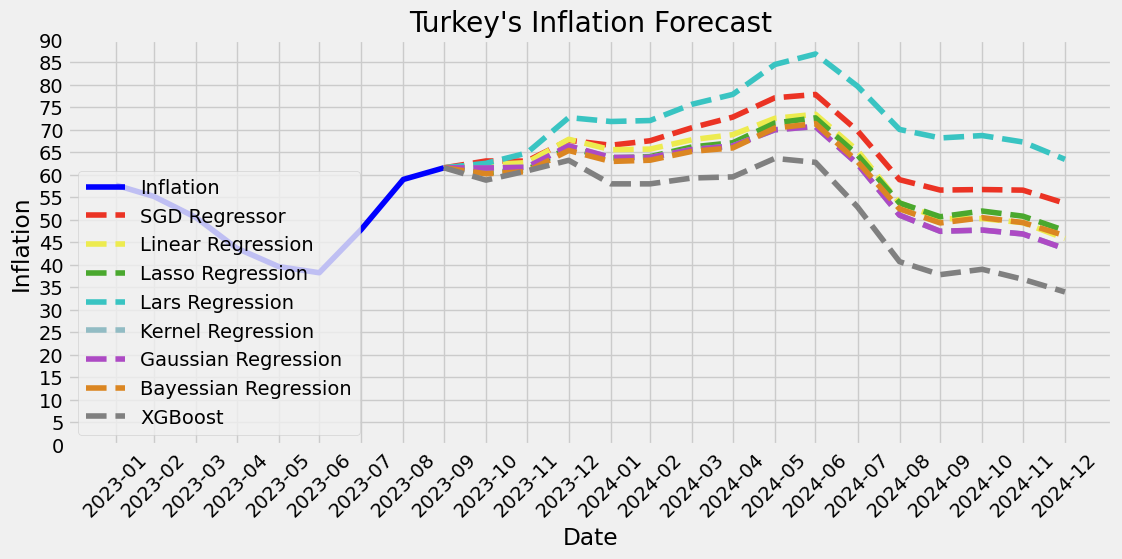

In [75]:








# Grafik çizdirelim
plt.figure(figsize=(12, 5))
plt.plot(df.iloc[191:200,1], label='Inflation', color='blue')
plt.plot(dfas.iloc[199:,0],'--',label=dfas.columns[0], color='#EB3324')
plt.plot(dfas.iloc[199:,1],'--',label=dfas.columns[1], color='#EDEB4F')
plt.plot(dfas.iloc[199:,2],'--',label=dfas.columns[2], color='#4AA82E')
plt.plot(dfas.iloc[199:,3],'--',label=dfas.columns[3], color='#39C4C2')
plt.plot(dfas.iloc[199:,4],'--',label=dfas.columns[4],color='#92BCC4')
plt.plot(dfas.iloc[199:,5],'--',label=dfas.columns[5],color='#AD4AC4')
plt.plot(dfas.iloc[199:,6],'--',label=dfas.columns[6],color='#DB8622')
plt.plot(dfas.iloc[199:,7],'--',label=dfas.columns[7],color='#808080')
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dfas.iloc[191:].index, dfas.iloc[191:].index.strftime('%Y-%m'), rotation=45)
y_max = 100
y_min = 10
y_interval = 0.5
y_ticks = [0]
while y_ticks[-1] < 90:
    y_ticks.append(y_ticks[-1] + 5)









# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation Forecast")
plt.legend(loc=3)
plt.grid(True)
plt.show()


In [79]:
eylül_tahmin=((tüfetahmin.iloc[0,:]/1614)-1)*100
np.abs(eylül_tahmin-4.75).sort_values()

Lars Regression         0.061413
Lasso Regression        0.152064
Kernel Regression       0.281163
Gaussian Regression     0.285390
Bayessian Regression    0.396164
XGBoost                 0.594162
Linear Regression       0.657680
DNN                     1.256835
SGD Regressor           1.394400
Name: 2023-09-30 00:00:00, dtype: float64

In [77]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
row=pd.DataFrame({eylül_tahmin.index[0]:eylül_tahmin[0],eylül_tahmin.index[1]:eylül_tahmin[1],eylül_tahmin.index[2]:eylül_tahmin[2],eylül_tahmin.index[3]:eylül_tahmin[3],eylül_tahmin.index[4]:eylül_tahmin[4],eylül_tahmin.index[5]:eylül_tahmin[5],eylül_tahmin.index[6]:eylül_tahmin[6],eylül_tahmin.index[7]:eylül_tahmin[7],eylül_tahmin.index[8]:eylül_tahmin[8]},index=pd.date_range(start="2023-09-30",end="2023-10-29",freq="1M"))
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin["Medyan"]=aylıktahmin.median(axis=1)
aylıktahmin

,SGD Regressor,Linear Regression,DNN,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,XGBoost,Ortalama,Medyan
2023-09-30,6.144400,5.407680,6.006835,4.597936,4.688587,5.031163,5.035390,4.353836,4.155838,5.046852,5.033277
2023-10-31,3.169416,3.372452,3.800870,3.025949,4.271223,3.256934,3.259002,3.107363,2.392530,3.295082,3.257968
2023-11-30,2.858949,3.160098,3.602301,3.275030,4.324876,2.987975,2.987797,3.191185,4.208601,3.399646,3.233108
2023-12-31,4.060845,4.412309,4.767453,4.306135,6.024470,4.154150,4.154969,4.143500,2.664483,4.298702,4.226835
2024-01-31,5.944890,5.180841,6.707996,5.153692,6.109444,5.009868,5.010164,5.075517,3.233922,5.269593,5.167267
2024-02-29,3.765899,3.228067,4.172983,3.339409,3.273968,3.140585,3.140610,3.319373,3.145504,3.391822,3.296670
2024-03-31,4.065059,3.580578,4.408157,3.636237,4.441518,3.382085,3.382451,3.526594,3.131115,3.728199,3.608407
2024-04-30,3.793912,3.065058,3.881434,2.955541,3.663718,2.881269,2.882721,2.858542,2.542698,3.169433,3.010300
2024-05-31,2.525022,2.190875,3.248457,2.663333,3.777698,2.205797,2.204087,2.697036,2.621222,2.681503,2.642277
2024-06-30,4.357138,4.469649,5.191876,4.619221,5.236630,4.355772,4.355171,4.534198,3.363585,4.498138,4.483894


In [80]:
yıllıktahmin=pd.DataFrame(dfas)
yıllıktahmin["Ortalama"]=yıllıktahmin.mean(axis=1)
yıllıktahmin["Medyan"]=yıllıktahmin.median(axis=1)
yıllıktahmin.tail(16)


,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,XGBoost,Ortalama,Medyan
2023-09-30,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865,61.529865
2023-10-31,63.050564,62.237529,60.451577,62.531691,61.477364,61.487095,60.203628,58.791095,61.278818,61.477364
2023-11-30,63.011237,62.673280,61.061774,64.808303,61.640925,61.650387,60.682324,60.835852,62.045510,61.650387
2023-12-31,67.648124,67.865609,66.033658,72.694697,66.387889,66.398936,65.384224,63.191258,66.950550,66.398936
2024-01-31,66.541380,65.554815,63.705815,71.821097,63.830694,63.842032,62.944258,57.965687,64.525722,63.842032
2024-02-29,67.543829,65.688069,64.014297,72.035857,63.823608,63.834986,63.219652,57.966388,64.765836,64.014297
2024-03-31,70.452118,67.779384,66.173730,75.655268,65.573491,65.585576,65.193670,59.266132,66.959921,66.173730
2024-04-30,72.796838,68.892963,67.098905,77.848197,66.375212,66.389705,65.956884,59.510649,68.108669,67.098905
2024-05-31,77.083716,72.518883,71.475441,84.487296,69.971896,69.983857,70.359417,63.621295,72.437725,71.475441
2024-06-30,77.827763,73.430532,72.628377,86.823790,70.683828,70.694855,71.365471,62.744444,73.274883,72.628377


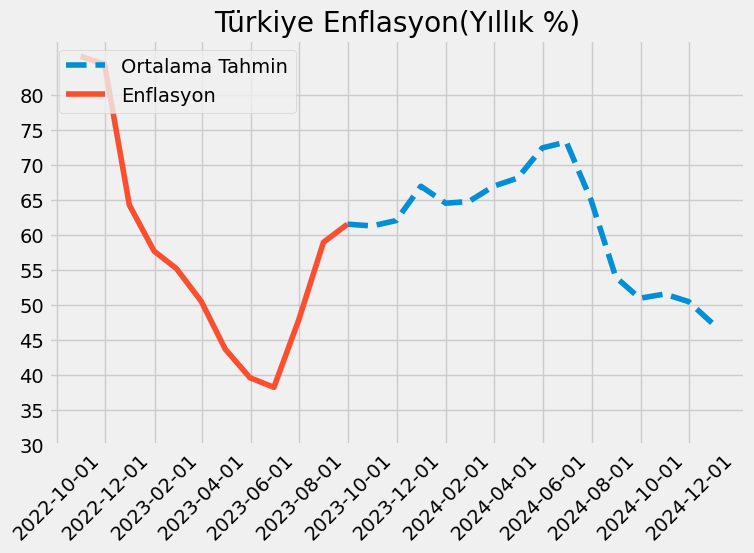

In [81]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,5))
plt.plot(yıllıktahmin["Ortalama"].tail(16),'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[-27:-15],label="Enflasyon")
plt.xticks(yıllıktahmin.tail(27).index.strftime("%Y-%m")[::2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()